In [3]:
%autosave 180
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Autosaving every 180 seconds


In [0]:
from keras import applications
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, BatchNormalization, Dropout, Flatten, Input, MaxPooling2D, Reshape
from keras import optimizers
from keras import backend as K
from keras.utils import to_categorical 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from sklearn.model_selection import train_test_split 

import pickle

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

import sys

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Load Data

X - набор сейсмических изображений.
y - набор разломов шириной в 1 пиксель, определенных вручную. 
Titles - название изображения, содержит информацию о номере разреза и координаты участка. 

In [6]:
path = '/content/gdrive/My Drive/разломы/data.pickle'
with open(path, 'rb') as handle:
    data = pickle.load(handle)  

X = data['X_set'] 
y = data['y_set'] 
Titles = data['fault_title'] 

X = X.reshape(X.shape + (1,))
y = y.reshape(y.shape + (1,))
y.shape

(10240, 64, 64, 1)

train_test_split - функция, отвечающая за разделение набора данных на тестовую и валидационную выборки

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.35, random_state=25)

y_train = to_categorical(y_train, num_classes=2) 
y_test = to_categorical(y_test, num_classes=2)
print('Train shape', x_train.shape)
print('Test shape', x_test.shape)

Train shape (6656, 64, 64, 1)
Test shape (3584, 64, 64, 1)


In [0]:
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy

    Variables:
        weights: numpy array of shape (C,) where C is the number of classes

    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """

    weights = K.variable(weights)

    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss

    return loss

#Model


In [0]:
from keras.layers import Input, Dense, Flatten, Reshape, Conv2D
from keras.models import Model
from keras.optimizers import Adam

def create_model(
        activation='relu',
        depth=5,
        batch_norm=.3,
        dropout=.2,
        activation_out='sigmoid',
        lr=.001,
        pooling=False,
        weight_false=0.35,
        weight_true=1,
):
    x = input_img = Input(shape=(64, 64, 1))

    neur = 2
    for i in range(depth):
      neur *= 2 if neur <= 32 else 64
      x = Conv2D(neur, (3, 3), activation=activation, padding='same')(x)
      x = BatchNormalization()(x) if batch_norm else x
      x = Dropout(dropout)(x) if dropout else x
      x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x) if pooling else x
        
    x = Flatten()(x)    
    x = Dense(100, activation=activation)(x)    
    x = Dropout(dropout)(x) if dropout else x
    x = Dense(64 * 64 * 2, activation=activation_out)(x)
    x = Reshape((64, 64, 2), input_shape=(64 * 64 * 2,))(x)
    
    loss = weighted_categorical_crossentropy(np.array([weight_false, weight_true]))
    
    model = Model(input_img, x, name="classification")
    model.compile(
        optimizer=Adam(lr=lr),
#         loss='binary_crossentropy', 
        loss=loss,
        metrics=['accuracy']
    )
    return model


In [10]:
model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 4)         40        
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 4)         16        
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 4)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 8)         296       
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 8)         32        
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 64, 8)         0         
__________

In [11]:
model.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=64,
    shuffle=True,
    validation_split=.3,
)

Train on 4659 samples, validate on 1997 samples
Epoch 1/100
4659/4659 [==============================] - 15s 3ms/step - loss: 0.1169 - acc: 0.9493 - val_loss: 0.1023 - val_acc: 0.9679
Epoch 2/100
4659/4659 [==============================] - 11s 2ms/step - loss: 0.0998 - acc: 0.9675 - val_loss: 0.1113 - val_acc: 0.9676
Epoch 3/100
4659/4659 [==============================] - 11s 2ms/step - loss: 0.0927 - acc: 0.9676 - val_loss: 0.1136 - val_acc: 0.9671
Epoch 4/100
4659/4659 [==============================] - 11s 2ms/step - loss: 0.0851 - acc: 0.9677 - val_loss: 0.1104 - val_acc: 0.9675
Epoch 5/100
4659/4659 [==============================] - 11s 2ms/step - loss: 0.0775 - acc: 0.9677 - val_loss: 0.0948 - val_acc: 0.9681
Epoch 6/100
4659/4659 [==============================] - 11s 2ms/step - loss: 0.0722 - acc: 0.9679 - val_loss: 0.1076 - val_acc: 0.9682
Epoch 7/100
4659/4659 [==============================] - 11s 2ms/step - loss: 0.0680 - acc: 0.9677 - val_loss: 0.0952 - val_acc: 0.9680


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

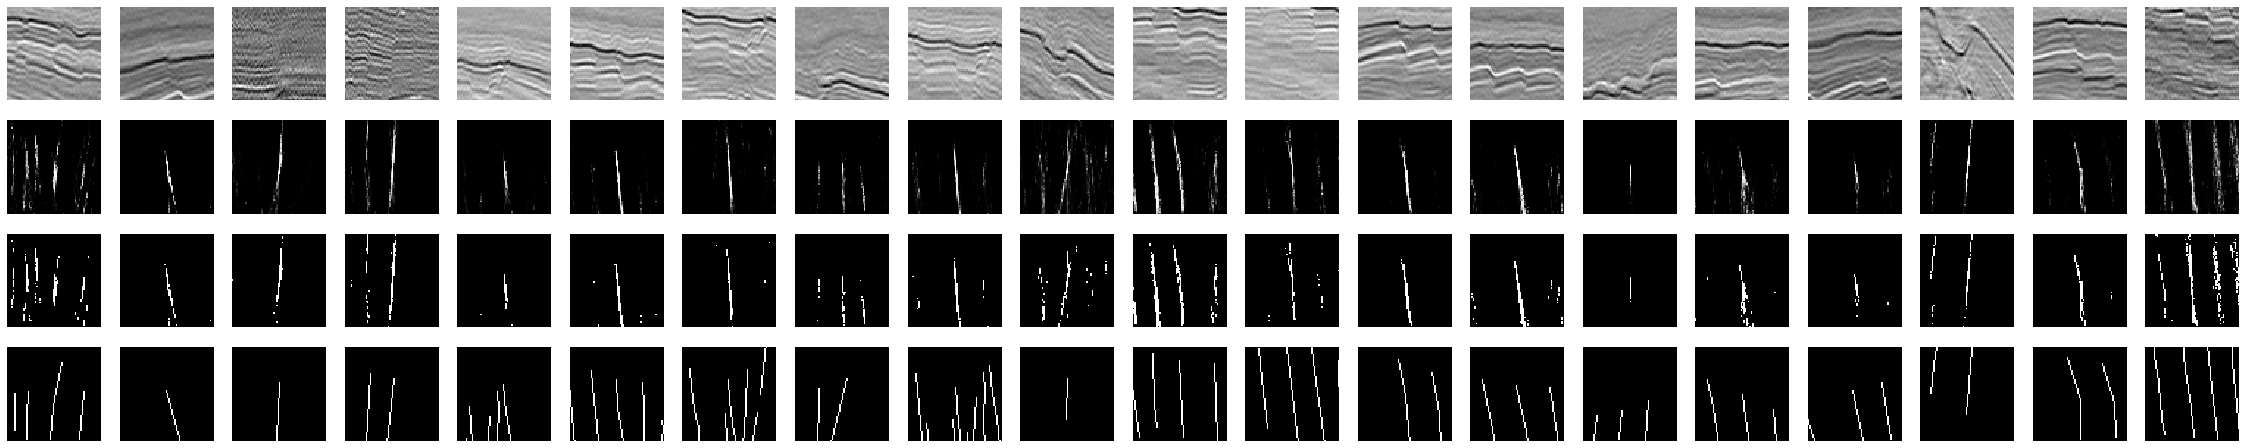

In [36]:
n = 20
trash = 0.3

answers = y_test[:n, :, :, 1:]
imgs = x_test[:n]
predicted = model.predict(imgs, batch_size=n)[:, :, :, 1:]
predicted_bool = predicted > trash
plot_digits(imgs, predicted, predicted_bool, answers)


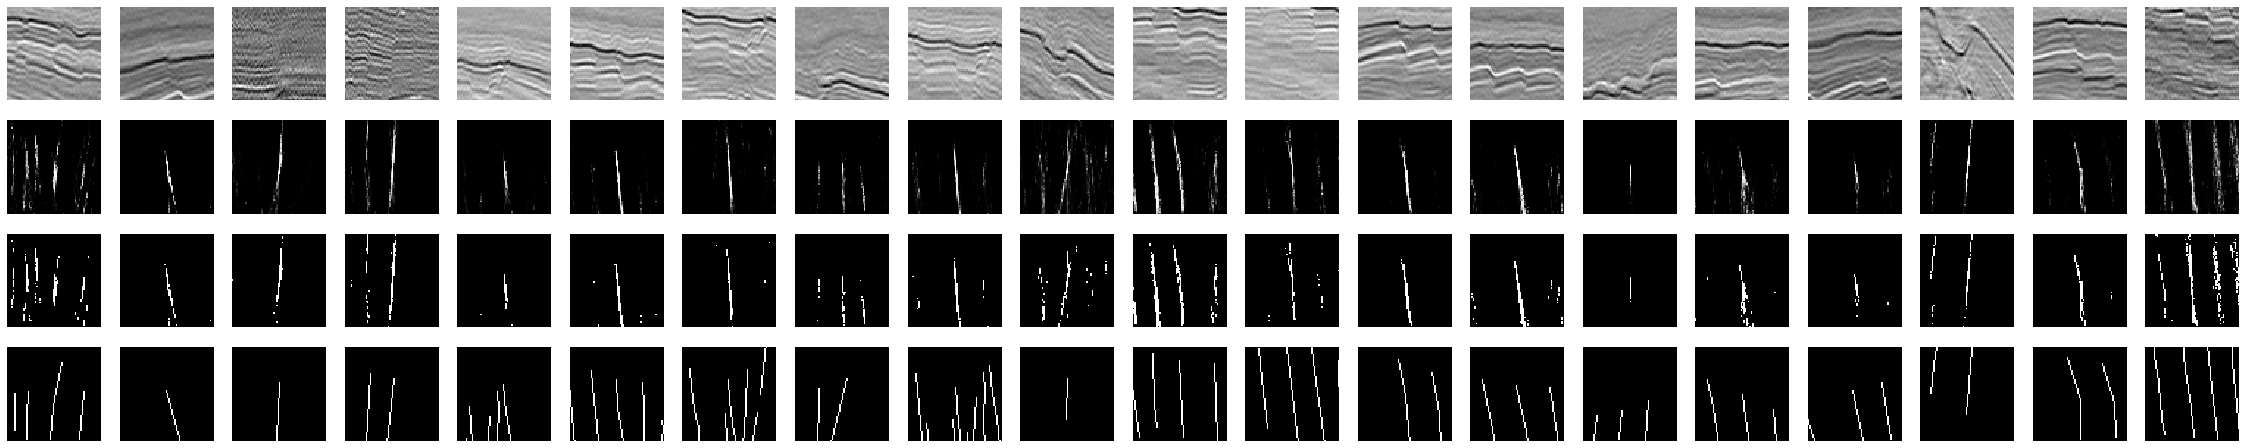

In [37]:

plot_digits(imgs, predicted, predicted_bool, answers)

In [0]:
from sklearn.metrics import classification_report
y_score = model.predict(x_test, batch_size=n)[:, :, :, 1:]
y_label = y_test[:, :, :, 1:] > trash

y_score = y_score.reshape([y_score.size,])
y_label = y_label.reshape([y_label.size,])


In [39]:
print(y_score.shape)
print(y_label.shape)

(35651584,)
(35651584,)


Text(0.5, 1.0, 'curve')

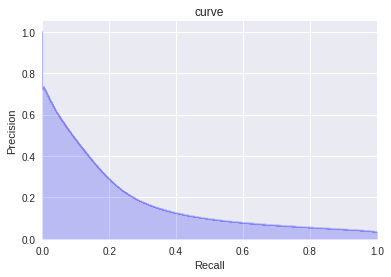

In [40]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

precision, recall, _ = precision_recall_curve(y_label, y_score)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('curve')